# Credit Card Fraud

Quels facteurs sur les transactions bancaires nous permettent de prédire une fraude à la carte bancaire ?

- EDA
- Preprocessing (ACP, feature selection)
- Modèles :
-* ML supervisé de classification binaire avec régression logistique, RandomForest, (régression linéaire pour les montants) ;
-* ML non supervisé avec clustering géographique DBScan Elbow+Silhouette
- Confrontation des résultats (quel serait le meilleur modèle pour prédire la fraude)
- Exemple de prédiction
- Mise en place du dashboard
- Proposer des questions d'ouverture (pour la présentation)

Si on a le temps : prédire le montant de la fraude (régression linéaire)

1. Import usual libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
data = pd.read_csv('src/fraud test.csv')
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [4]:
data['is_fraud'].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [24]:
data.shape

(555719, 23)

In [29]:
data_non_frauds = data.loc[(data['is_fraud'] == 0),:].sample(2145, random_state=0)
data_frauds = data[data['is_fraud'] == 1]

data_sample = pd.concat([data_frauds, data_non_frauds], join='outer')
data_sample = data_sample.sample(frac=1)
data_sample.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
31777,31777,01/07/2020 22:28,3.597930e+15,fraud_Gutmann-Upton,misc_pos,9.84,Derrick,Flores,M,83690 Nicholas Ports Apt. 846,...,35.2229,-89.5518,9496,Furniture conservator/restorer,23/03/1993,1c6095eddc249e1f04c61620fd2a5735,1372717732,35.635036,-89.182217,0
78315,78315,18/07/2020 22:03,2.454080e+15,fraud_Kuphal-Predovic,misc_net,828.22,Robert,Andrade,M,27720 Martin Hills,...,47.0874,-93.9196,2097,Insurance risk surveyor,27/10/1987,9917b85781e97bdebb160301ab984360,1374185000,47.829339,-93.985386,1
224279,224279,08/09/2020 22:15,5.702730e+11,fraud_Miller-Hauck,grocery_pos,321.51,Peter,Edwards,M,96122 Steven Flat,...,32.6064,-83.2095,112,"Lecturer, higher education",03/02/1965,f9d56e3a0ceb2f7a8fc856f740d2a1fd,1378678518,33.243766,-83.178324,1
354011,354011,04/11/2020 23:38,3.719850e+14,fraud_Spencer-Runolfsson,misc_pos,50.37,Benjamin,Martin,M,0495 Baker Manors,...,42.9576,-75.4838,1970,"Programmer, multimedia",09/06/1949,b646873eaa7d6a33c74910b668f738ce,1383608331,43.228994,-74.899820,1
373526,373526,13/11/2020 22:16,3.048760e+13,"fraud_Streich, Dietrich and Barton",shopping_net,1070.36,Stephanie,Crane,F,144 Martinez Curve,...,38.0970,-86.1723,350,Counsellor,05/01/1955,bade4c2c1aefb1fb7222474a89359a6b,1384380965,38.150576,-85.721508,1


In [31]:
data_sample.shape

(4290, 23)

In [15]:
data_sample['is_fraud'].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [33]:
to_drop = ['cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'trans_num']
data_sample = data_sample.drop(columns=to_drop)
data_sample.shape

(4290, 15)

In [17]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["alcohol"]
target_variable = "quality"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

X :
   alcohol
0      9.4
1      9.8
2      9.8
3      9.8
4      9.4


In [18]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [19]:
print("Preprocessing X_train...")
print(X_train.head())
print()
preprocessor = StandardScaler()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print() 

# Test pipeline
print("Preprocessing X_test...")
print(X_test.head())
print()
X_test = preprocessor.transform(X_test)
print("...Done!")
print(X_test[0:5,:]) # X_test is now a numpy array
print() 

Preprocessing X_train...
      alcohol
642       9.4
679       9.6
473      10.6
390      12.9
1096     10.8

...Done!
[[-0.95579434]
 [-0.76727388]
 [ 0.17532846]
 [ 2.34331382]
 [ 0.36384892]]

Preprocessing X_test...
      alcohol
1109     10.8
1032      9.6
1002     11.7
487      10.0
979      10.4

...Done!
[[ 0.36384892]
 [-0.76727388]
 [ 1.21219102]
 [-0.39023294]
 [-0.01319201]]



In [20]:
# Train model
print("Train model...")
baseline = LogisticRegression()
baseline.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [21]:
# Print accuracy
print("accuracy score on training set : ", baseline.score(X_train, Y_train))
print("accuracy score on test set : ", baseline.score(X_test, Y_test))

accuracy score on training set :  0.5465207193119624
accuracy score on test set :  0.578125


7. Use cross-validation with cv=10 to get a better feel of the model's average performance on this dataset.

In [22]:
# Perform 10-fold cross-validation 
print("10-fold cross-validation...")
scores = cross_val_score(baseline, X_train, Y_train, cv=10)
print('The cross-validated accuracy is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated accuracy is :  0.5410617618110236
The standard deviation is :  0.027051325500817094


c:\Users\pierr\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



8. What would be the test accuracy for a "dummy" model that would always predict the most frequent class? Is the baseline model interesting?

From question 5., we know that the most frequent class is `quality = 5`. Let's create a list Y_pred_dummy in which every element is equal to 5, and compute the accuracy:

In [23]:
Y_test_pred_dummy = [5]*len(Y_test)
print("dummy accuracy on test set : ", accuracy_score(Y_test, Y_test_pred_dummy))

dummy accuracy on test set :  0.421875


The baseline model is already much more efficient than a dummy model!

9. Train a multivariate model by including all the features and compute its accuracy on train/test.

Hint1: Do the explanatory variables need imputation, encoding or normalization? If so proceed to the necessary transformations. Why is normalization important when using logistic regression?

Hint2: If you get a "convergence warning" while training the model, you might want to increase the value of the argument "max_iter" in the LogisticRegression 🤓

In [24]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])


Number of rows : 1599

Display of dataset: 


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



Basics statistics: 


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000



Percentage of missing values: 


fixed_acidity           0.0
volatile_acidity        0.0
citric_acid             0.0
residual_sugar          0.0
chlorides               0.0
free_sulfur_dioxide     0.0
total_sulfur_dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

The preprocessings are again quite simple here:
* no missing values imputation
* all the features are numeric, so we want to apply a StandardScaler to the whole X array (this is crucial, especially if we plan to interpret the model's coefficients)
* The target is categorical (multiclass) but is already encoded as integer values, so there's no need for a LabelEncoder

In [25]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "quality"

X = dataset.drop(target_variable, axis = 1)
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

X :
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.

In [26]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [27]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = scaler.transform(X_test) # Don't fit again !!
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
812            10.8              0.45         0.33             2.5      0.099   
1249            7.1              0.60         0.01             2.3      0.079   
1421            7.5              0.40         0.18             1.6      0.079   
157             7.1              0.43         0.42             5.5      0.071   
377             9.4              0.27         0.53             2.4      0.074   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
812                  20.0                  38.0  0.99818  3.24       0.71   
1249                 24.0                  37.0  0.99514  3.40       0.61   
1421                 24.0                  58.0  0.99650  3.34       0.58   
157                  28.0                 128.0  0.99730  3.42       0.71   
377                   6.0                  18.0  0.99620  3.20       1.13   

      al

In [28]:
# Train model
print("Train model...")
classifier = LogisticRegression(max_iter = 1000)
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [29]:
# Print accuracy
print("accuracy score on training set : ", classifier.score(X_train, Y_train))
print("accuracy score on test set : ", classifier.score(X_test, Y_test))

accuracy score on training set :  0.6004691164972635
accuracy score on test set :  0.61875


10. Is this model significantly better than the baseline?

In [30]:
# Perform 10-fold cross-validation 
print("10-fold cross-validation...")
scores = cross_val_score(classifier, X_train, Y_train, cv=10)
print('The cross-validated accuracy is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...


c:\Users\pierr\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



The cross-validated accuracy is :  0.5910986712598425
The standard deviation is :  0.05437570023889957


The multivariate model is just slightly better than the baseline. 

11. Extract the model's predictions on train/test sets. Use these values to plot the confusion matrices.

In [31]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred[:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred[:5])
print()


Predictions on training set...
...Done.
[6 6 5 5 7]

Predictions on test set...
...Done.
[6 6 5 6 6]



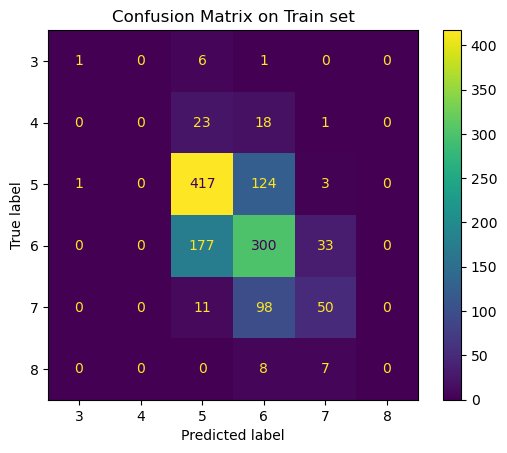

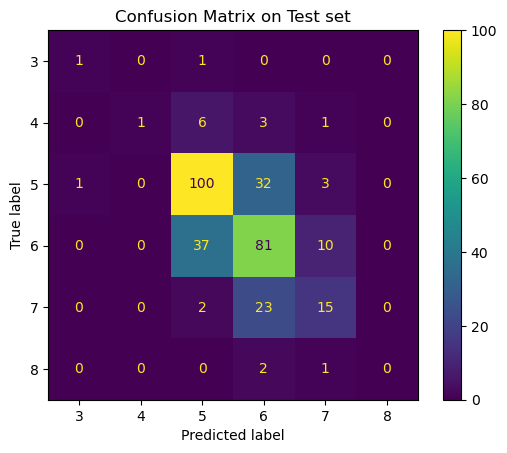

In [32]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

12. Analyze the model's coefficients. Can you deduce easily what are the most important features to predict the wine quality?

In [33]:
print('Coefficients of the Logistic regression model:')
classifier.coef_

Coefficients of the Logistic regression model:


array([[ 0.27475783,  1.11111673, -0.11934497, -0.06266476,  0.88431261,
         0.4009792 , -0.99544519,  0.44073298,  0.65454341, -0.5092293 ,
        -0.83666126],
       [ 0.43162113,  0.41074275,  0.00146886,  0.17007934,  0.37166178,
        -0.37606089,  0.29995228, -0.49481693,  0.42420066, -0.34244837,
        -0.71628399],
       [-0.57630058,  0.04174114,  0.10255601, -0.27256304,  0.18849432,
        -0.16575236,  0.83454887,  0.40952806, -0.21210348, -0.39019108,
        -0.60676216],
       [-0.19916375, -0.37912627, -0.19688884, -0.16427731,  0.10003052,
         0.01996808,  0.3662384 ,  0.13577815, -0.16821523, -0.00928464,
         0.21137696],
       [ 0.40659337, -0.70027208, -0.09126679,  0.24776367, -0.51188268,
         0.0484215 ,  0.07276221, -0.37355596, -0.06761856,  0.45223871,
         0.64329162],
       [-0.337508  , -0.48420228,  0.30347573,  0.08166209, -1.03261655,
         0.07244447, -0.57805658, -0.11766631, -0.63080681,  0.79891468,
         1.305

In [34]:
# Create a pandas DataFrame with the model's coefficients
coefs = pd.DataFrame(index = X.columns, data = classifier.coef_.transpose(), columns=[3, 4, 5, 6, 7, 8])
coefs

,3,4,5,6,7,8
fixed_acidity,0.274758,0.431621,-0.576301,-0.199164,0.406593,-0.337508
volatile_acidity,1.111117,0.410743,0.041741,-0.379126,-0.700272,-0.484202
citric_acid,-0.119345,0.001469,0.102556,-0.196889,-0.091267,0.303476
residual_sugar,-0.062665,0.170079,-0.272563,-0.164277,0.247764,0.081662
chlorides,0.884313,0.371662,0.188494,0.100031,-0.511883,-1.032617
free_sulfur_dioxide,0.400979,-0.376061,-0.165752,0.019968,0.048422,0.072444
total_sulfur_dioxide,-0.995445,0.299952,0.834549,0.366238,0.072762,-0.578057
density,0.440733,-0.494817,0.409528,0.135778,-0.373556,-0.117666
pH,0.654543,0.424201,-0.212103,-0.168215,-0.067619,-0.630807
sulphates,-0.509229,-0.342448,-0.390191,-0.009285,0.452239,0.798915


In multiclass classification, one logistic regression is fitted independently for each category. That's why we get as many sets of coefficients as there are different values of the target! In this case, interpreting the coefficients is much more difficult. To conclude about feature importance, it would be more convenient to use a Chi2 test.

13. Use Chi2 test in order to analyse the importance of each variable in your dataset. You may find more information on this test following this link : [scikitlearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html)

In [35]:
from sklearn.feature_selection import chi2
feature_importance = chi2(X, Y)
feature_importance 

(array([1.12606524e+01, 1.55802891e+01, 1.30256651e+01, 4.12329474e+00,
        7.52425579e-01, 1.61936036e+02, 2.75555798e+03, 2.30432045e-04,
        1.54654736e-01, 4.55848775e+00, 4.64298922e+01]),
 array([4.64500416e-02, 8.15035154e-03, 2.31394417e-02, 5.31804675e-01,
        9.79968040e-01, 3.82728810e-33, 0.00000000e+00, 1.00000000e+00,
        9.99526491e-01, 4.72096321e-01, 7.42403757e-09]))

14. Put these values into a DataFrame for more readability.

In [36]:
feature_ranking = pd.DataFrame(columns=X.columns, data=feature_importance, 
                               index=["Chi2 Score", "P-value"]).transpose().sort_values("Chi2 Score")
feature_ranking = feature_ranking.reset_index().rename({'index': 'feature'}, axis = 1)
feature_ranking

,feature,Chi2 Score,P-value
0,density,0.000230,1.000000e+00
1,pH,0.154655,9.995265e-01
2,chlorides,0.752426,9.799680e-01
3,residual_sugar,4.123295,5.318047e-01
4,sulphates,4.558488,4.720963e-01
5,fixed_acidity,11.260652,4.645004e-02
6,citric_acid,13.025665,2.313944e-02
7,volatile_acidity,15.580289,8.150352e-03
8,alcohol,46.429892,7.424038e-09
9,free_sulfur_dioxide,161.936036,3.827288e-33


15. Create a barchart visualization, what can you conclude ?

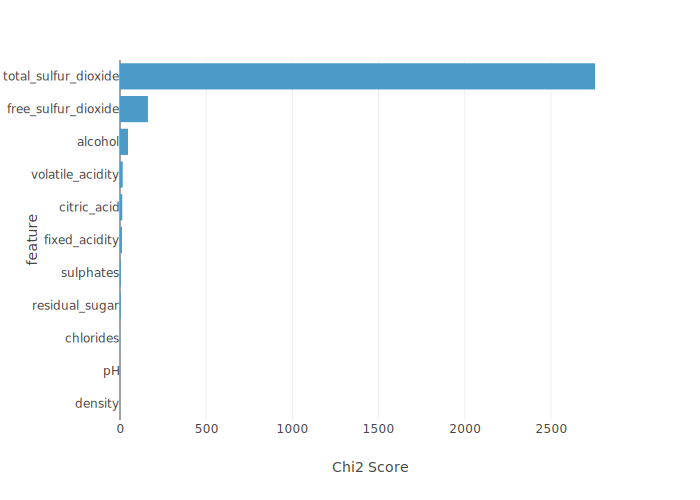

In [37]:
fig = px.bar(feature_ranking, y = 'feature', x = 'Chi2 Score')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

Surprisingly, the total sulfur dioxide and free sulfur dioxide seem to be the most important features, whereas this didn't strike at first glance from the basic EDA.

16. Try fitting the same model using the argument class_weight="balanced", what are the consequences on all the aspects of the performances studied before ?

In [38]:
classifier = LogisticRegression(class_weight="balanced") # takes into account the different classes' proportions
classifier.fit(X_train, Y_train)
Y_test_pred = classifier.predict(X_test)
# Print accuracy
print("accuracy score on training set : ", classifier.score(X_train, Y_train))
print("accuracy score on test set : ", classifier.score(X_test, Y_test))

accuracy score on training set :  0.4253322908522283
accuracy score on test set :  0.403125


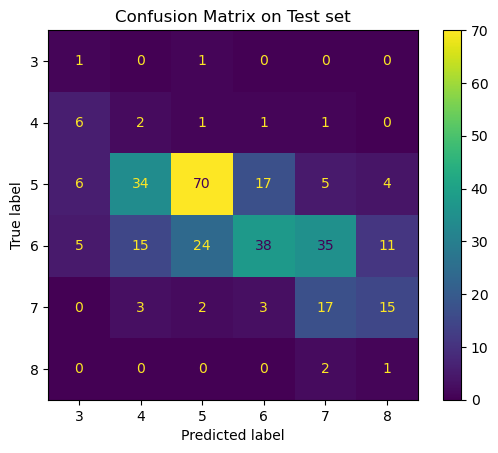

In [39]:
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_pred, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

**The model's performances have been deteriorated, but now all the classes are treated with equal importances, which means that the model tries to make good predictions even for rare classes**

21. As an extra question for which no fixed solution will be proposed, attempt to improve the score using feature engineering (create new variables using common functions, combining variables together in a non-linear way etc...)